In [1]:
## General Dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys, os
import glob
from tika import parser # pip install tika
import inspect

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
#from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import ldaseqmodel


## Preprocessing
import spacy
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast

## Other Libraries
from operator import itemgetter

## ScikitLearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## Load csv as a dataframe

DTM_timeslices_df = pd.read_csv("Test_Files\DTM_timeslices.csv", index_col=0) 
DTM_timeslices_df.head()

<>:3: DeprecationWarning: invalid escape sequence \D
<>:3: DeprecationWarning: invalid escape sequence \D
<>:3: DeprecationWarning: invalid escape sequence \D
<ipython-input-2-8ba02c9a8ed4>:3: DeprecationWarning: invalid escape sequence \D
  DTM_timeslices_df = pd.read_csv("Test_Files\DTM_timeslices.csv", index_col=0)


,0,1,2
0,"[('weight', 0.025465142691823296), ('obesity',...","[('hypertension', 0.044738512594628264), ('pat...","[('bmi', 0.0313089344325822), ('obesity', 0.02..."
1,"[('weight', 0.019459611996995297), ('obesity',...","[('hypertension', 0.04487143104699833), ('pati...","[('bmi', 0.03219253759845819), ('obesity', 0.0..."
2,"[('weight', 0.015893125054497883), ('obesity',...","[('hypertension', 0.04803282394718758), ('pati...","[('bmi', 0.033326816717185855), ('obesity', 0...."
3,"[('weight', 0.013149599633825398), ('obesity',...","[('hypertension', 0.06331846475196334), ('pati...","[('bmi', 0.034449558035721216), ('obesity', 0...."
4,"[('weight', 0.011894640301383066), ('activity'...","[('hypertension', 0.08124174944193192), ('pati...","[('bmi', 0.0359809495074056), ('obesity', 0.02..."


In [3]:
print(DTM_timeslices_df.keys())
# DTM_timeslices_df.head()

# rename columns
DTM_timeslices_df.rename(columns = {'0':'Topic_0', '1': 'Topic_1', '2':'Topic_2' }, inplace = True) 

# iterating the columns 
for col in DTM_timeslices_df.columns: 
    print(col) 

DTM_timeslices_df.head()

Index(['0', '1', '2'], dtype='object')
Topic_0
Topic_1
Topic_2


,Topic_0,Topic_1,Topic_2
0,"[('weight', 0.025465142691823296), ('obesity',...","[('hypertension', 0.044738512594628264), ('pat...","[('bmi', 0.0313089344325822), ('obesity', 0.02..."
1,"[('weight', 0.019459611996995297), ('obesity',...","[('hypertension', 0.04487143104699833), ('pati...","[('bmi', 0.03219253759845819), ('obesity', 0.0..."
2,"[('weight', 0.015893125054497883), ('obesity',...","[('hypertension', 0.04803282394718758), ('pati...","[('bmi', 0.033326816717185855), ('obesity', 0...."
3,"[('weight', 0.013149599633825398), ('obesity',...","[('hypertension', 0.06331846475196334), ('pati...","[('bmi', 0.034449558035721216), ('obesity', 0...."
4,"[('weight', 0.011894640301383066), ('activity'...","[('hypertension', 0.08124174944193192), ('pati...","[('bmi', 0.0359809495074056), ('obesity', 0.02..."


In [17]:
## Create a function to convert the topic string (literally displayed as dict) to dictionary
def convert_toDict(topic):
    topic_i=[]
    for line in topic:
        sub={}
        line = ast.literal_eval (line)
        for tup in line:
            sub[tup[0]]=tup[1]
        topic_i.append(sub)
    return topic_i

## Create a function to get terms and their probabilities from all topics
def get_term_prob (term, topic):
    term_list=[]
    for item in topic:
        #print("This is item:", item)
        #print("This is item keys:", item.keys())
        if term in item.keys():
            #print("This is term:", term)
            for k, v in item.items():
                if k ==term:
                    term_list.append(v)
        else:
            term_list.append(0)
    return term_list


<>:264: DeprecationWarning: invalid escape sequence \D
<>:264: DeprecationWarning: invalid escape sequence \D
<>:264: DeprecationWarning: invalid escape sequence \D
<ipython-input-19-ac6d4d41ca23>:264: DeprecationWarning: invalid escape sequence \D
  fig.savefig("Test_Files\DTM_timeslices.png")


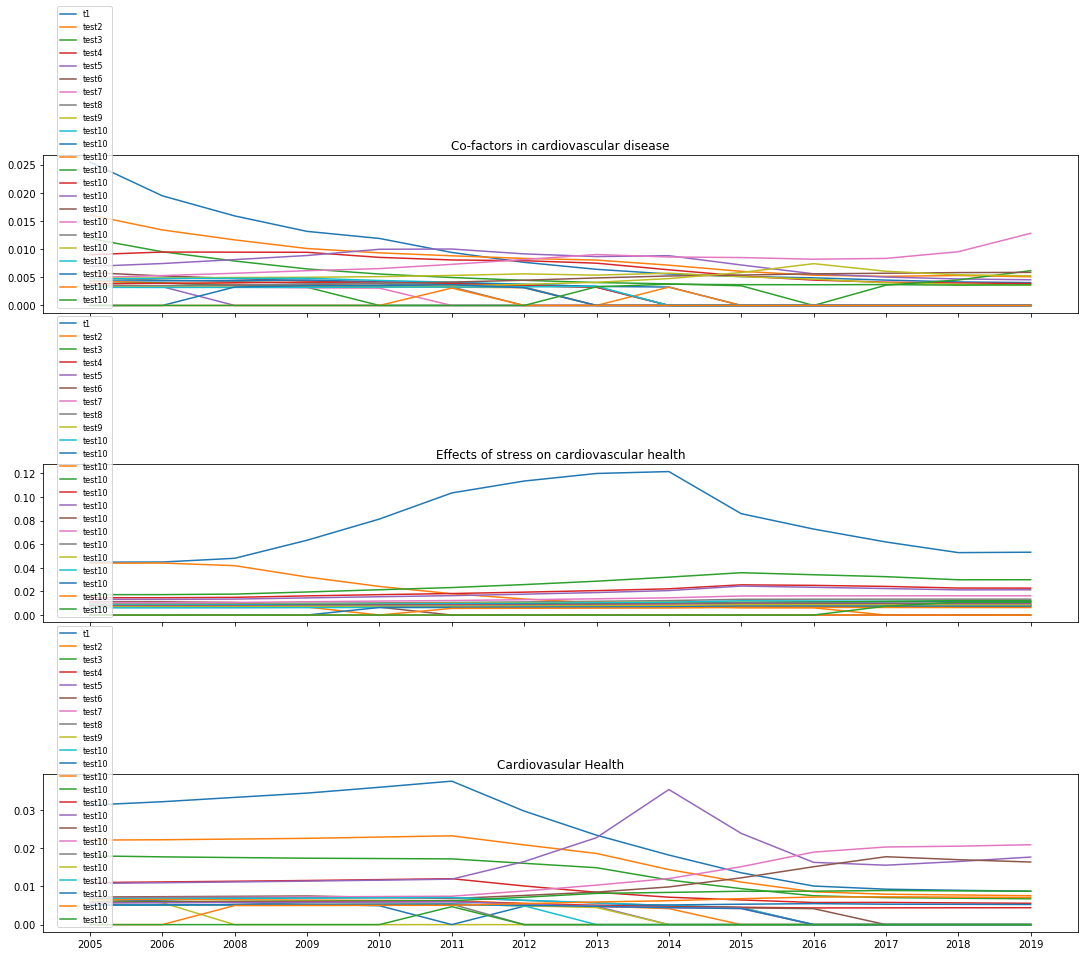

In [19]:
# Extract terms and term probabilities from the topics to save separately

# Topic 0
topic_0 = convert_toDict(DTM_timeslices_df['Topic_0'])
weight_0 = get_term_prob("weight",topic_0)
obesity_0 = get_term_prob("obesity",topic_0)
bmi_0 = get_term_prob("bmi",topic_0)
diabetes_0 = get_term_prob("diabetes",topic_0)
activity_0 = get_term_prob("activity",topic_0)
kg_0 = get_term_prob("kg",topic_0)
patient_0 = get_term_prob("patient",topic_0)
gain_0 = get_term_prob("gain",topic_0)
cholesterol_0 = get_term_prob("cholesterol",topic_0)
develop_0 = get_term_prob("develop",topic_0)
type_0 = get_term_prob("type",topic_0)
triglyceride_0 = get_term_prob("triglyceride",topic_0)
smoker_0= get_term_prob("smoker",topic_0)
metabolic_syndrome_0 = get_term_prob("metabolic_syndrome",topic_0)
prevalence_0 = get_term_prob("prevalence",topic_0)
al_0 = get_term_prob("al",topic_0)
blood_pressure_0 = get_term_prob("blood_pressure",topic_0)
diet_0 = get_term_prob("diet",topic_0)
child_0= get_term_prob("child",topic_0)
exercise_0 = get_term_prob("exercise",topic_0)
uric_acid_0 = get_term_prob("uric_acid",topic_0)
serum_uric_acid_0 = get_term_prob("serum_uric_acid",topic_0)
gender_0 = get_term_prob("gender",topic_0)
show_0 = get_term_prob("show",topic_0)
effect_0 = get_term_prob("effect",topic_0)
value_0 = get_term_prob("value",topic_0)
case_0 = get_term_prob("case",topic_0)
use_0 = get_term_prob("use",topic_0)
test_0 = get_term_prob("test",topic_0)
score_0 = get_term_prob("score",topic_0)
normal_0 = get_term_prob("normal",topic_0)
student_0 = get_term_prob("student",topic_0)

# Topic 1
topic_1 = convert_toDict(DTM_timeslices_df['Topic_1'])
hypertension_1 = get_term_prob("hypertension",topic_1)
patient_1 = get_term_prob("patient",topic_1)
psychological_1 = get_term_prob("psychological",topic_1)
stress_1 = get_term_prob("stress",topic_1)
distress_1 = get_term_prob("distress",topic_1)
pci_1 = get_term_prob("pci",topic_1)
sample_1 = get_term_prob("sample",topic_1)
al_1 = get_term_prob("al",topic_1)
control_1 = get_term_prob("control",topic_1)
activity_1= get_term_prob("activity",topic_1)
non_1 = get_term_prob("non", topic_1)
coronary_1 = get_term_prob("coronary", topic_1)
case_1 = get_term_prob("case", topic_1)
blood_pressure_1 = get_term_prob("blood_pressure", topic_1)
pakistani_1 = get_term_prob("pakistani", topic_1)
pakistan_1= get_term_prob("pakistan", topic_1)
history_1 = get_term_prob("history", topic_1)
family_1 = get_term_prob("family", topic_1)
smoking_1 = get_term_prob("smoking", topic_1)
gender_1 = get_term_prob("gender", topic_1)
obesity_1 = get_term_prob("obesity", topic_1)
anthropometric_lifestyle_correlates_1= get_term_prob("anthropometric_lifestyle_correlates", topic_1)
reward_1 = get_term_prob("reward", topic_1)




# Topic 2
topic_2 = convert_toDict(DTM_timeslices_df['Topic_2'])
bmi_2 = get_term_prob("bmi", topic_2)
obesity_2= get_term_prob("obesity", topic_2)
overweight_2= get_term_prob("overweight", topic_2)
student_2= get_term_prob("student", topic_2)
anger_2= get_term_prob("anger", topic_2)
depression_2= get_term_prob("depression", topic_2)
family_2= get_term_prob("family", topic_2)
obese_2= get_term_prob("obese", topic_2)
valvular_2= get_term_prob("valvular", topic_2)
weight_2= get_term_prob("weight", topic_2)
prevalence_2= get_term_prob("prevalence", topic_2)
pulmonary_function_2= get_term_prob("pulmonary_function", topic_2)
pakistan_2= get_term_prob("pakistan", topic_2)
impact_2= get_term_prob("impact", topic_2)
fev_fvc_2= get_term_prob("fev_fvc", topic_2)
test_2= get_term_prob("test", topic_2)
male_2= get_term_prob("male", topic_2)
fev_fvc_ratio_2= get_term_prob("fev_fvc_ratio", topic_2)
fvc_2= get_term_prob("fvc", topic_2)
fev_2= get_term_prob("fev", topic_2)
male_2= get_term_prob("male", topic_2)
show_2= get_term_prob("show", topic_2)
mass_index_2= get_term_prob("mass_index", topic_2)
stress_2= get_term_prob("stress", topic_2)
socio_demographic_2= get_term_prob("socio_demographic", topic_2)
anxiety_2= get_term_prob("anxiety", topic_2)
psychiatric_morbidity_2= get_term_prob("psychiatric_morbidity", topic_2)
agression_2= get_term_prob("agression", topic_2)
correlate_2= get_term_prob("correlate", topic_2)
income_2= get_term_prob("income", topic_2)
mental_2= get_term_prob("mental", topic_2)
non_2= get_term_prob("non", topic_2)
diabetes_2 = get_term_prob("diabetes",topic_2)
pci_2 = get_term_prob("pci",topic_2)
stroke_2 = get_term_prob("stroke",topic_2)
coronary_2 = get_term_prob("coronary",topic_2)
obesity_2 = get_term_prob("obesity",topic_2)
pakistan_2 = get_term_prob("pakistan",topic_2)
stent_2 = get_term_prob("stent",topic_2)
depression_2 = get_term_prob("depression",topic_2)
cabg_2 = get_term_prob("cabg",topic_2)


# Plot the topic evolution graph
# Create subplots
fig, (plt1,plt2, plt3) = plt.subplots(3,1,figsize=(15, 13), sharex=True, constrained_layout=True)

# Create a function to plot lines within subplots
def plot_line (t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23, plt, str_label):
    x=np.array(["2005", "2006", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])
    plt.plot(x, t1, label = convert_VarTostr(t1))
    plt.plot(x, t2, label = 'test2')
    plt.plot(x, t3, label = 'test3')
    plt.plot(x, t4, label = 'test4')
    plt.plot(x, t5, label = 'test5')
    plt.plot(x, t6, label = 'test6')
    plt.plot(x, t7, label = 'test7')
    plt.plot(x, t8, label = 'test8')
    plt.plot(x, t9, label = 'test9')
    plt.plot(x, t10,label = 'test10')
    plt.plot(x, t11,label = 'test10')
    plt.plot(x, t12,label = 'test10')
    plt.plot(x, t13,label = 'test10')
    plt.plot(x, t14,label = 'test10')
    plt.plot(x, t15,label = 'test10')
    plt.plot(x, t16,label = 'test10')
    plt.plot(x, t17,label = 'test10')
    plt.plot(x, t18,label = 'test10')
    plt.plot(x, t19,label = 'test10')
    plt.plot(x, t20,label = 'test10')
    plt.plot(x, t21,label = 'test10')
    plt.plot(x, t22,label = 'test10')
    plt.plot(x, t23,label = 'test10')
    plt.set_title(str_label)
    plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.005), fontsize=8)
#     print("This is t1:", t1)
 
    return plt

def convert_VarTostr(var):
    #print("This is var: ", var)
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    #print("This is callers:", callers_local_vars)
    f= [var_name for var_name, var_val in callers_local_vars if var_val is var]
    #print("this is f:", f)
    #print("this is var_name: ", var_name)
    #print("this is var_val: ", var_val)
    return f[0]

## Resources
## https://stackoverflow.com/questions/55760681/how-to-get-the-list-name-passed-as-a-parameter-to-a-function-in-python

# Plot subgraphs by using created functions

plt1=plot_line(weight_0,
               obesity_0,
               bmi_0,
               diabetes_0,
               activity_0,
               kg_0,
               patient_0,
               gain_0,
               cholesterol_0,
               develop_0,
               type_0, 
               triglyceride_0,
               smoker_0, 
               metabolic_syndrome_0, 
               prevalence_0, 
               al_0, 
               blood_pressure_0, 
               diet_0, 
               child_0, 
               exercise_0, 
               uric_acid_0, 
               serum_uric_acid_0,
               gender_0,
               #show_0,
               #effect_0,
               #value_0,
               #case_0,
               #use_0,
               #test_0,
               #score_0,
               #normal_0,
               #student_0,
               plt1, 
               'Co-factors in cardiovascular disease')


plt2=plot_line(hypertension_1,
               patient_1, 
               psychological_1,
               stress_1,
               distress_1,
               pci_1, 
               sample_1,
               al_1,
               control_1,
               activity_1,
               non_1, 
               coronary_1, 
               case_1, 
               blood_pressure_1, 
               pakistani_1, 
               pakistan_1, 
               history_1, 
               family_1, 
               smoking_1, 
               gender_1, 
               obesity_1,
               anthropometric_lifestyle_correlates_1,
               reward_1,
               plt2, 
               'Effects of stress on cardiovascular health')


plt3=plot_line(bmi_2,
                obesity_2,
                overweight_2,
                student_2,
                anger_2,
                depression_2,
                family_2,
                obese_2,
                valvular_2,
                weight_2,
                prevalence_2,
                pulmonary_function_2,
                pakistan_2,
                impact_2,
                fev_fvc_2,
                test_2,
                male_2,
                fev_fvc_ratio_2,
                fvc_2,
                fev_2,
                male_2,
                show_2,
                mass_index_2,
                #stress_2,
                #socio_demographic_2,
                #anxiety_2,
                #psychiatric_morbidity_2,
                #agression_2,
                #correlate_2,
                #income_2,
                #mental_2,
                #non_2,
                plt3, 
               'Cardiovasular Health')


                                                           
# Save the graph
fig.savefig("Test_Files\DTM_timeslices.png")